# Sakila Data Warehouse: Business Intelligence Analysis

#### Notebook Context

This notebook represents the Analytical Layer of the Sakila Data Engineering project. Following the successful execution of the Incremental ETL Pipeline (which denormalized the raw transactional data into a Star Schema), this notebook serves two purposes:

1. Validation: Verifies that the `sakila_star` data warehouse [Source 7] is correctly populated and schema relationships (Facts & Dimensions) are intact.
2. Business Intelligence: Demonstrates how the optimized schema enables complex analytical queries—ranging from customer segmentation to financial forecasting, that would be computationally expensive on a normalized transactional database.

#### Technical Setup
- **Database:** sakila_star (MySQL 8.0 running in Docker)
- **Schema Architecture:** Star Schema
> Fact Table: fact_rental (Transactional metrics)  
> Dimension Tables: dim_customer, dim_film, dim_store, etc.
    
- **Tooling:** JupySQL for direct SQL querying, Pandas for data manipulation, and Seaborn / matplodtlib for visualization.

#### Key Analysis Modules
We will answer six critical business questions to derive actionable insights:
1. **Catalog Diversity:** What is the distribution of unique titles across film genres?
2. **Top Products:** Which movies generate the highest revenue within their specific MPAA rating?
3. **Operational Compliance:** What is the ratio of On-Time vs. Late returns?
4. **Customer Value:** How are customers segmented by payment tiers (Low/Mid/High)?
5. **VIP Behaviour:** What are the specific category preferences of our Top 20 highest-spending customers?
6. **Financial Health:** What is the store's month-over-month revenue growth trajectory?

<br>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, display

# Sets visualization style
sns.set_theme(style="whitegrid")

In [2]:
!pip install jupysql

%load_ext sql
%sql mysql+pymysql://app:app_password@db/sakila_star

Connecting to 'mysql+pymysql://app:***@db/sakila_star'

<br> 

# Film Database Analysis: 

### 1. Catalog Distribution: Unique Films per Category

This analysis quantifies the diversity of our rental catalog by counting the **Unique Films Rented** within each genre.
    
By joining `dim_category` with the transactional data in `fact_rental`, we calculate the volume of distinct titles per genre to visualize which categories (e.g., Action vs. Drama) offer the widest selection to our customers.

In [3]:
%%sql df_category_film_counts <<
WITH
  film_category AS (
    SELECT DISTINCT
      fr.category_id,
      c.name,
      fr.film_id
    FROM
      fact_rental AS fr
      JOIN dim_category AS c ON fr.category_id = c.category_id
  )
SELECT
  fc.name,
  COUNT(fc.film_id) AS films
FROM
  film_category AS fc
GROUP BY
  fc.category_id
ORDER BY
  fc.category_id;

Running query in 'mysql+pymysql://app:***@db/sakila_star'

16 rows affected.

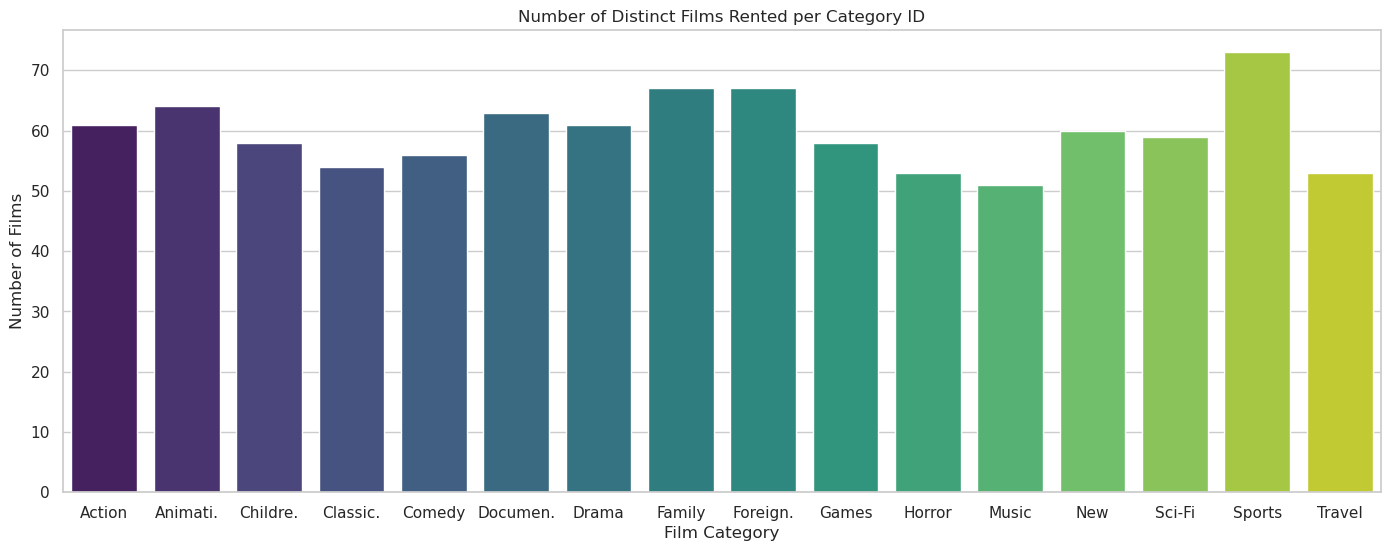

In [4]:
# 1. Convert the JupySQL ResultSet to a Pandas DataFrame
df = df_category_film_counts.DataFrame()
df['short_name'] = df['name'].apply(lambda x: x[:7] + "." if len(x) > 6 else x)

# 2. Plot the data
plt.figure(figsize=(17, 6))
sns.barplot(
    data=df, 
    x='short_name', 
    y='films', 
    hue='short_name',  # <--- Explicitly map color to the category name
    palette='viridis', 
    legend=False       # <--- Hide the legend since the X-axis labels already explain the colors
)

plt.title("Number of Distinct Films Rented per Category ID")
plt.xlabel("Film Category")
plt.ylabel("Number of Films")
plt.show()

# ===== #

# 3. Calculate the average
average_films = df['films'].mean()

# 4. Print the result
display(HTML(f"""
<div style="font-size: 24px; font-weight: regular;">
    Average films per category: <strong style="font-size: 30px; font-weight: bold;">{average_films:.2f}</strong>
</div>
"""))


<br>

### 2. Highest Grossing Movie By Rating

This analysis identifies the #1 Top Revenue-Generating Film for each specific MPAA rating category (G, PG, PG-13, R, NC-17).

By aggregating the total amount from fact_rental and joining it with dim_film [Source 23, 51], we apply a Window Function (RANK) to isolate the specific movie titles that outperform their peers within their target demographic.

In [5]:
%%sql df_top_movies <<
WITH movies_amount_rating AS(
    SELECT
        dim_film.title,
        dim_film.rating,
        SUM(fact_rental.amount) AS amount
    FROM
        fact_rental
        INNER JOIN dim_film ON dim_film.film_id = fact_rental.film_id
    GROUP BY
        title,
        rating
),
movies_ranking AS (
    SELECT
        title,
        rating,
        amount,
        RANK() over (
            PARTITION BY rating
            ORDER BY
                amount DESC
        ) AS rank_movies
    FROM
        movies_amount_rating
)
SELECT
    title,
    rating,
    amount
FROM
    movies_ranking
WHERE
    rank_movies = 1;

Running query in 'mysql+pymysql://app:***@db/sakila_star'

5 rows affected.

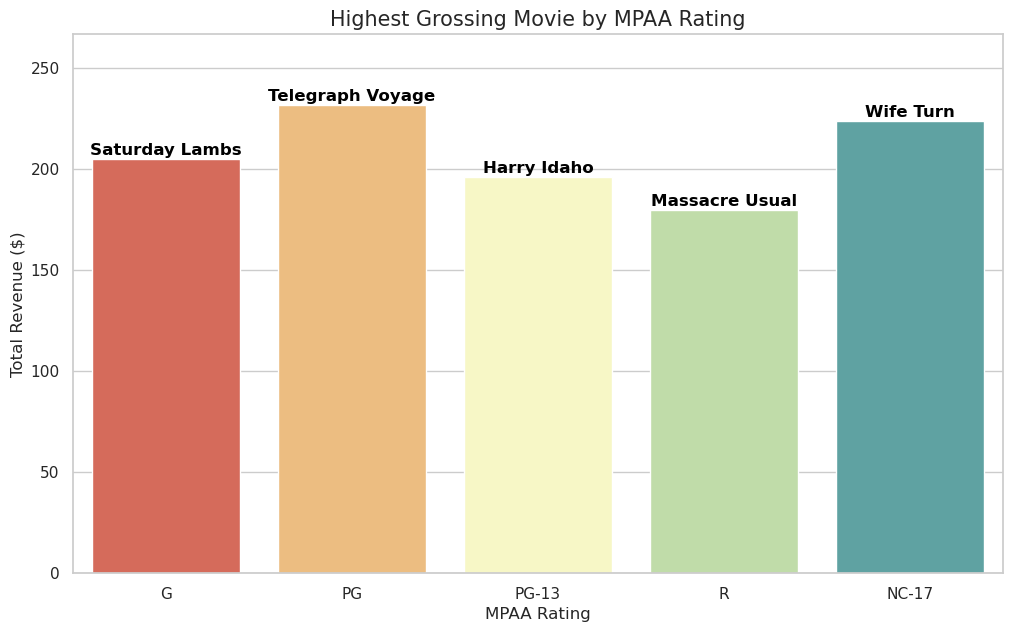

In [6]:

# 1. Convert to DataFrame
df = df_top_movies.DataFrame()

# 2. Convert Decimal amount to float (Essential for plotting)
df['amount'] = df['amount'].astype(float)

# 3. Create the Plot
plt.figure(figsize=(12, 7))

# Define a custom order for ratings if you want them logically sorted (optional)
rating_order = ['G', 'PG', 'PG-13', 'R', 'NC-17']

ax = sns.barplot(
    data=df, 
    x='rating', 
    y='amount', 
    hue='rating',      
    palette='Spectral', 
    order=rating_order,
    dodge=False        # Ensures bars are centered
)

# 4. Add the Movie Titles on top of the bars
for index, row in df.iterrows():
    # Find the X-position of the current rating
    # (We filter the dataframe to find where this rating sits in the order)
    try:
        x_loc = rating_order.index(row['rating'])
        
        # Place text: Center it (ha='center'), slightly above the bar (y + 2)
        ax.text(
            x_loc, 
            row['amount'] + 2, 
            row['title'].title(), # .title() makes it "Title Case"
            ha='center', 
            fontweight='bold', 
            color='black'
        )
    except ValueError:
        pass # Safety in case a rating is missing from the data

# 5. Styling
plt.title("Highest Grossing Movie by MPAA Rating", fontsize=15)
plt.xlabel("MPAA Rating")
plt.ylabel("Total Revenue ($)")
plt.ylim(0, df['amount'].max() * 1.15) # Add 15% headroom for the text labels
plt.legend([],[], frameon=False)       # Hide the redundant legend
plt.show()

<br>

# Customer-Specific Analytics

### 1. Customer Compliance: On-Time vs. Late Return Analysis

This analysis evaluates customer adherence to rental terms by quantifying the ratio of _'On-Time'_ versus _'Late'_ returns.
    
By comparing the actual possession time (calculated from `fact_rental` dates) against the specific `rental_duration` allowed per movie in `dim_film`, we classify every transaction to visualize the scale of overdue inventory and potential late fee generation.

In [7]:
%%sql df_delivery <<
SELECT
  CASE
  -- Compare actual duration (in hours) vs allowed duration (days * 24)
    WHEN (
      EXTRACT(
        HOUR
        FROM
          TIMEDIFF (fact_rental.return_date, fact_rental.rental_date)
      )
    ) > (dim_film.rental_duration * 24) THEN 'Late'
    ELSE 'On time'
  END AS delivery_status,
  COUNT(*) AS count
FROM
  fact_rental
  INNER JOIN dim_film ON dim_film.film_id = fact_rental.film_id
WHERE
  fact_rental.return_date IS NOT NULL
GROUP BY
  delivery_status;

Running query in 'mysql+pymysql://app:***@db/sakila_star'

2 rows affected.

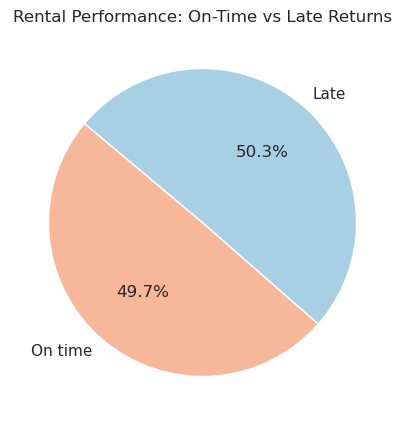

In [8]:
# 1. Convert the SQL ResultSet to a Pandas DataFrame
df_delivery_plot = df_delivery.DataFrame()

# 2. Plot using Matplotlib (Seaborn doesn't have a pie chart function)
plt.figure(figsize=(5, 5))

# Generate the same 'RdBu' colors you liked
colors = sns.color_palette('RdBu', n_colors=len(df_delivery_plot))

plt.pie(
    df_delivery_plot['count'], 
    labels=df_delivery_plot['delivery_status'], 
    autopct='%1.1f%%',       # Add percentage labels
    startangle=140,          # Rotate it slightly for better aesthetics
    colors=colors            # Apply the Red/Blue palette
)

plt.title("Rental Performance: On-Time vs Late Returns")
plt.show()

<br>

### 2. Customer Spending Behavior: Payment Tier Analysis

This analysis segments daily rental baskets into **3 Tiers** to identify customer spending patterns: 
- Low Tier (transactions below \$3),
- Mid Tier (transactions between \$3-6),   
- High Tier (transactions that are more than $6)  
       


By joining financial data from `fact_rental` with user profiles in `dim_customer`, we visualize the distribution of payment amounts to understand the frequency of high-value interactions versus standard rentals.


In [9]:
%%sql df_customer_value <<
WITH
  max_amount_customer AS (
    SELECT
      fr.customer_id,
      MAX(fr.amount) AS max_amount,
      DATE(fr.payment_date) AS payment_date
    FROM
      fact_rental AS fr
    WHERE
      fr.amount IS NOT NULL
    GROUP BY
      fr.customer_id,
      DATE (fr.payment_date)
  )
SELECT
  CONCAT (UPPER(dc.first_name), ' ', UPPER(dc.last_name)) AS full_name,
  max_ac.max_amount,
  max_ac.payment_date,
  CASE
    WHEN max_ac.max_amount < 3 THEN 'Low Value'
    WHEN max_ac.max_amount >= 3
    AND max_ac.max_amount < 6 THEN 'Mid Value'
    WHEN max_ac.max_amount >= 6 THEN 'High Value'
  END AS value_rate
FROM
  dim_customer AS dc
  INNER JOIN max_amount_customer AS max_ac ON dc.customer_id = max_ac.customer_id
ORDER BY
  max_ac.max_amount DESC;

Running query in 'mysql+pymysql://app:***@db/sakila_star'

10896 rows affected.

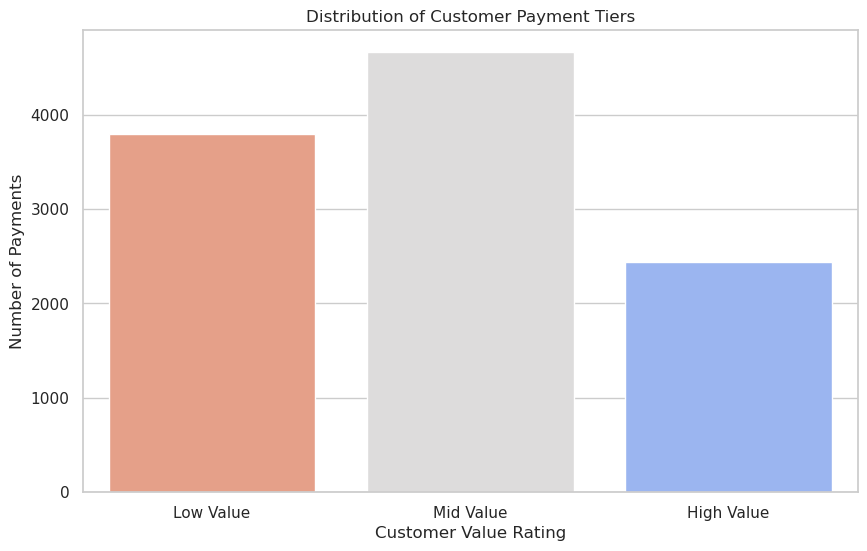

In [10]:

# 1. Convert to DataFrame
df = df_customer_value.DataFrame()

# 2. Plot the distribution of Value Ratings
plt.figure(figsize=(10, 6))

# Use countplot to count how many rows belong to each category automatically
sns.countplot(
    data=df, 
    x='value_rate', 
    palette='coolwarm', 
    order=['Low Value', 'Mid Value', 'High Value'], # Force specific order
    hue='value_rate',
    legend=False,
)

plt.title("Distribution of Customer Payment Tiers")
plt.xlabel("Customer Value Rating")
plt.ylabel("Number of Payments")
plt.show()

<br>

### 3. VIP Analysis: Category Preferences of Top 20 Spenders
This analysis identifies the store's top 10 customers based on **Lifetime Value** (total spending). It performs a cross-tabulation of their spending habits to reveal specific category preferences (e.g., *Action* vs. *Drama*).
*   **Method:** SQL CTEs filter for top spenders and pivot the `fact_rental` amount by category.
*   **Visualization:** A Heatmap displaying the total USD amount spent per category.


In [11]:
%%sql df_top_customers <<
WITH top_spenders AS (
    SELECT
        customer_id
    FROM
        fact_rental
    GROUP BY
        customer_id
    ORDER BY
        SUM(amount) DESC
    LIMIT 20
),
customer_category_sum AS (
    -- 2. Get the category breakdown ONLY for those 10 customers
    SELECT
        CONCAT(dc.first_name, ' ', dc.last_name) AS full_name,
        dcat.name AS category,
        SUM(fr.amount) AS amount
    FROM
        fact_rental AS fr
        JOIN top_spenders AS ts ON fr.customer_id = ts.customer_id  -- <--- The Filter
        JOIN dim_customer AS dc ON dc.customer_id = fr.customer_id
        JOIN dim_category AS dcat ON dcat.category_id = fr.category_id
    GROUP BY
        full_name,
        category
)
SELECT
    ccs.full_name,
    -- 3. Pivot the data (same logic as before)
    MAX(CASE WHEN category = 'Family' THEN amount ELSE 0 END) AS "Family",
    MAX(CASE WHEN category = 'Games' THEN amount ELSE 0 END) AS "Games",
    MAX(CASE WHEN category = 'Animation' THEN amount ELSE 0 END) AS "Animation",
    MAX(CASE WHEN category = 'Classics' THEN amount ELSE 0 END) AS "Classics",
    MAX(CASE WHEN category = 'Documentary' THEN amount ELSE 0 END) AS "Documentary",
    MAX(CASE WHEN category = 'Sports' THEN amount ELSE 0 END) AS "Sports",
    MAX(CASE WHEN category = 'New' THEN amount ELSE 0 END) AS "New",
    MAX(CASE WHEN category = 'Children' THEN amount ELSE 0 END) AS "Children",
    MAX(CASE WHEN category = 'Music' THEN amount ELSE 0 END) AS "Music",
    MAX(CASE WHEN category = 'Travel' THEN amount ELSE 0 END) AS "Travel"
FROM
    customer_category_sum AS ccs
GROUP BY
    ccs.full_name;

Running query in 'mysql+pymysql://app:***@db/sakila_star'

20 rows affected.

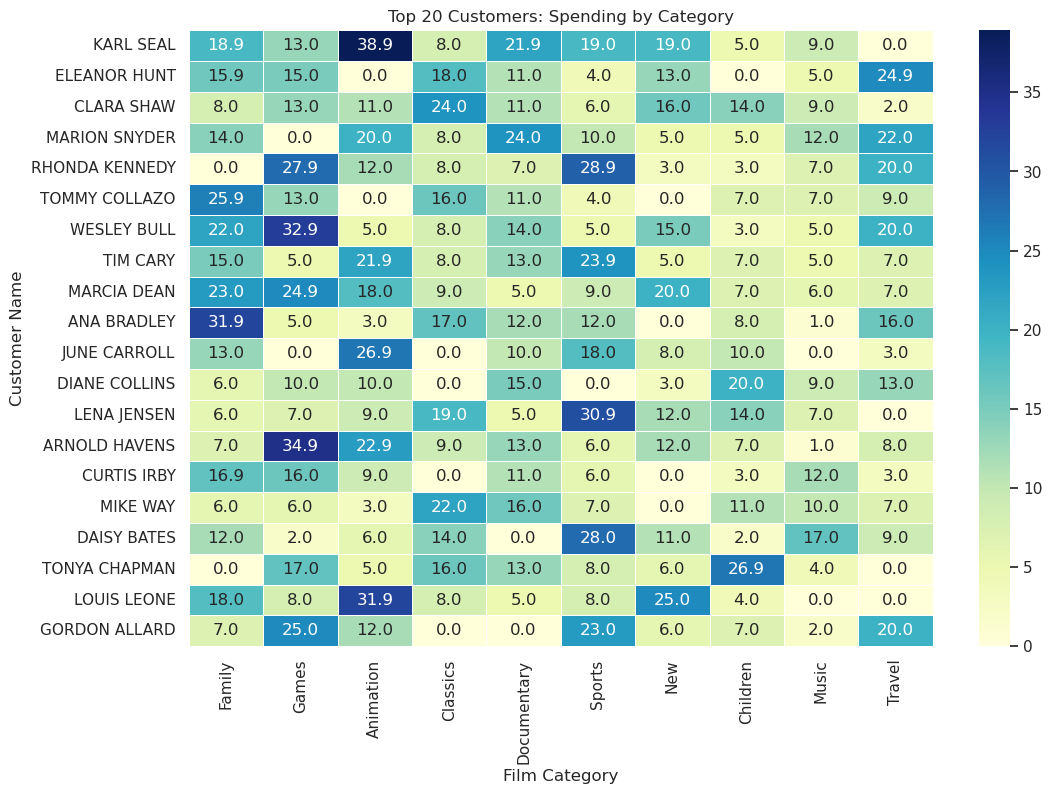

In [12]:

# 1. Convert to DataFrame
df = df_top_customers.DataFrame()

# 2. FIX 1: Move 'full_name' to the index so it becomes the row label, not data
df.set_index('full_name', inplace=True)

# 3. FIX 2: Convert the remaining data from SQL 'Decimal' objects to Python 'float'
df = df.astype(float)

# 4. Create the Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    df, 
    annot=True,       # Show numbers
    fmt=".1f",        # Format decimals
    cmap="YlGnBu",    # Yellow-Green-Blue colors
    linewidths=.5
)

plt.title("Top 20 Customers: Spending by Category")
plt.xlabel("Film Category")
plt.ylabel("Customer Name")
plt.show()

<br>

### 4. Store Performance: Month-over-Month Revenue Growth

This analysis tracks the financial trajectory of the store by calculating the Net Change in Revenue between consecutive months.
- Method: By aggregating rental payments from fact_rental [Source 51] and applying the SQL LAG() window function, we subtract the previous month's total from the current month's total.
- Insight: The resulting visualization highlights financial volatility, instantly identifying periods of growth (positive values) versus decline (negative values) in the store's income stream.

In [13]:
%%sql df_revenue_diff <<
WITH monthly_revenue AS (
    SELECT
        -- Format as 'YYYY-MM' to keep chronological order safe
        DATE_FORMAT(payment_date, '%Y-%m') AS payment_month,
        SUM(amount) AS total_gross
    FROM
        fact_rental
    WHERE
        payment_date IS NOT NULL
    GROUP BY
        payment_month
)
SELECT
    payment_month,
    total_gross,
    -- Get previous month's value
    LAG(total_gross, 1) OVER (ORDER BY payment_month) AS prev_month_gross,
    -- Calculate Difference (Growth/Decline)
    total_gross - LAG(total_gross, 1) OVER (ORDER BY payment_month) AS monthly_diff
FROM
    monthly_revenue
ORDER BY
    payment_month;

Running query in 'mysql+pymysql://app:***@db/sakila_star'

5 rows affected.

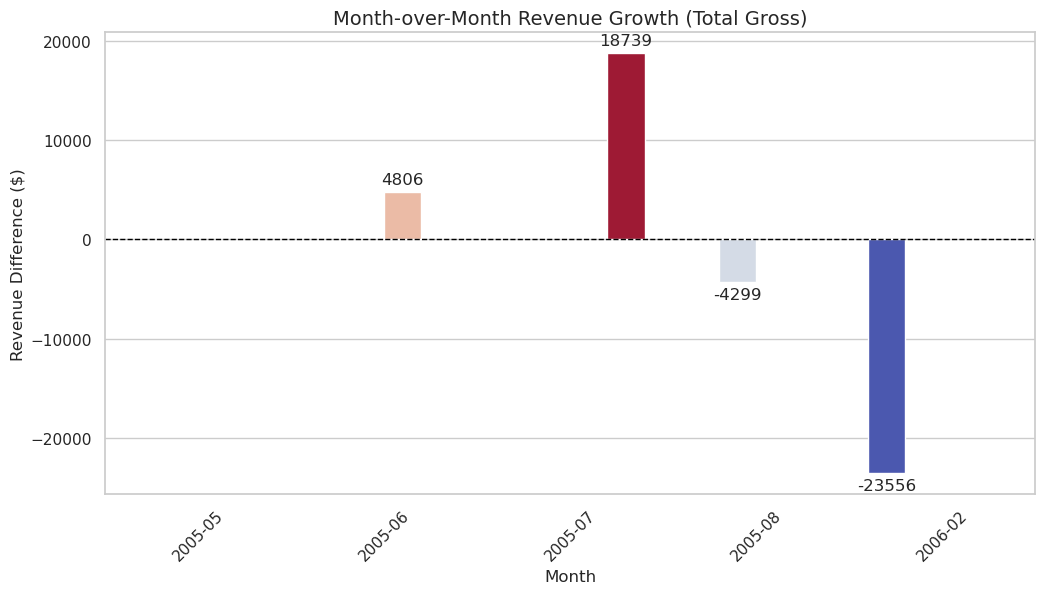

In [14]:
# 1. Convert to DataFrame
df = df_revenue_diff.DataFrame()

# 2. Convert Decimal to Float
df['total_gross'] = df['total_gross'].astype(float)
df['monthly_diff'] = df['monthly_diff'].astype(float)

# 3. Create the Plot
plt.figure(figsize=(12, 6))

# We use 'monthly_diff' for the Y-axis
chart = sns.barplot(
    data=df, 
    x='payment_month', 
    y='monthly_diff', 
    palette='coolwarm', # Red = Negative (Drop), Blue = Positive (Growth)
    hue='monthly_diff', # Coloring based on value
    legend=False
)

# 4. Add a zero line for reference
plt.axhline(0, color='black', linewidth=1, linestyle='--')

# 5. Add Labels
plt.title("Month-over-Month Revenue Growth (Total Gross)", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Revenue Difference ($)")
plt.xticks(rotation=45) # Rotate dates if they overlap

# Optional: Add value labels on bars
for p in chart.patches:
    chart.annotate(f'{p.get_height():.0f}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9 if p.get_height() > 0 else -9), 
                   textcoords = 'offset points')

plt.show()

<br>

## Conclusion
This analysis confirms that the **Sakila Star Schema** is successfully optimized for analytical queries. 
- We successfully integrated `fact_rental` with all Level 1 and Level 2 dimension tables.
- We identified that **Animation** and **Sports** are key revenue drivers for our VIP customers.
- We detected volatility in Month-over-Month revenue that warrants further investigation into inventory stocking.


> For better Graphical Representation, visit: http://localhost:3000
